# DIverse Counterfactual Explanations (DICE)

In this tutorial, you will learn how to implement a specific type of post-hoc explanations: counterfactual explanations. But what do counterfactual explanations mean?. This kind of explanations is intended to show how the model works by creating hypothetical examples  with a prediction with respect to the initial studied instance. In order to do so, we are going to focus on the application of DiCE(original article: Mothilal et al.[[1](https://arxiv.org/pdf/1905.07697.pdf)]) using the framework developped by Mothilal, Sharma and Tan https://github.com/interpretml/DiCE.



## How DiCE generate counterfactual explanations?

The main idea is to generate a set of k counterfactual examples $\{c_1, c_2, ..., c_k\}$ such the decision of the model $f$ given an instance $x$ changes. However, we have to take into account that generating counterfactual examples with a high number of features that have changed is not the ideal approach (Diversity). In the other hand we need to consider counterfactual examples that are close to the original instance $x$ (Proximity) otherwise the explanations will not be useful. 

Diversity via Determinantal Point Process:

\begin{gather}
dpp\_diversity  = det(K) 
\end{gather}
where $K_{i,j} = \frac{1}{1+dist(c_i,c_j)} $ and $dist(c_i,c_j)$ is a distanc metric.

Proximity:
\begin{gather}
Proximity  := -\frac{1}{k} \sum_{i=1}^{k} dist(c_i, x) 
\end{gather}

Beyond these main constraints, DiCE allows us to implement constraints that are related to "real world" problems (e.g., an upper bound for some variables)


Based on these definitions DiCE considers the next loss function to be optimized.

\begin{gather}
C(x)  = arg\;min_{c_1, c_2, ..., c_k} \frac{1}{k}\sum_{i=1}^{k} yloss(f(c_i), y) + \frac{\lambda_1}{k} \sum_{i=1}^{k} dist(c_i, x) \\ - \lambda_2 dpp\_diversity(c_1, c_2, ..., c_k)
\end{gather}

where $yloss()$ is a function that measures the distance between $f(c_i)$ and the desired outcome $y$. Both $\lambda_1$ and $\lambda_2$ are hyperparameters that balance the three parts of the loss function.

## Use Case: Bipolar Disease Crisis Prediction

Now we understand how to generate counterfactual explanations, let's focus on a familiar use case in which counterfactual examples are  interesting: Bipolar Disease Crisis Prediction.

Bipolar disorder, formerly called manic depression, is a mental health condition that causes extreme mood swings that include emotional highs (mania or hypomania) and lows (depression) which often come accompanied by different features (i.e., physical and psychological features).

In this notebook we will create a Bipolar Disease Crisis Prediciton Model using the data available [here](https://datasets.simula.no/depresjon/) and then apply Dice in order to generate counterfactual explanations that will help psychiatrists to understand the causes behind a potential patient tendency towards a mania or depression episode.

The use case is organized as follows:
1. We load the processed data.
2. We develop a Machine Learning based model for the bipolar disease prediction: the [XGBoost](https://arxiv.org/abs/1603.02754).
3. We apply DiCE to generate counterfactual explanations (https://github.com/interpretml/DiCE).


In [1]:
%run ../src/setup.py
%run ../src/process_data.py

### Setting the Environment


In [2]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

pd.set_option("max_rows", 500)
pd.set_option("max_columns", 500)


import matplotlib.pyplot as plt
import seaborn as sns
plt.rc("font", size=16)

from sklearn import metrics
from sklearn import model_selection



In [70]:
path_features = "../data/features.csv"
path_target = "../data/target.csv"
features = pd.read_csv(path_features)
#features["edu"] = features["edu"].astype(str)
features["edu"] = features["edu"].apply(lambda x: x if isinstance(x, str) else "0")
features.replace(to_replace={np.nan: 0.0}, inplace=True)
target = pd.read_csv(path_target)

### Target Distribution

- Bipolar II: **1**

- Unipolar Depressive: **0** 

<AxesSubplot:xlabel='# Cases'>

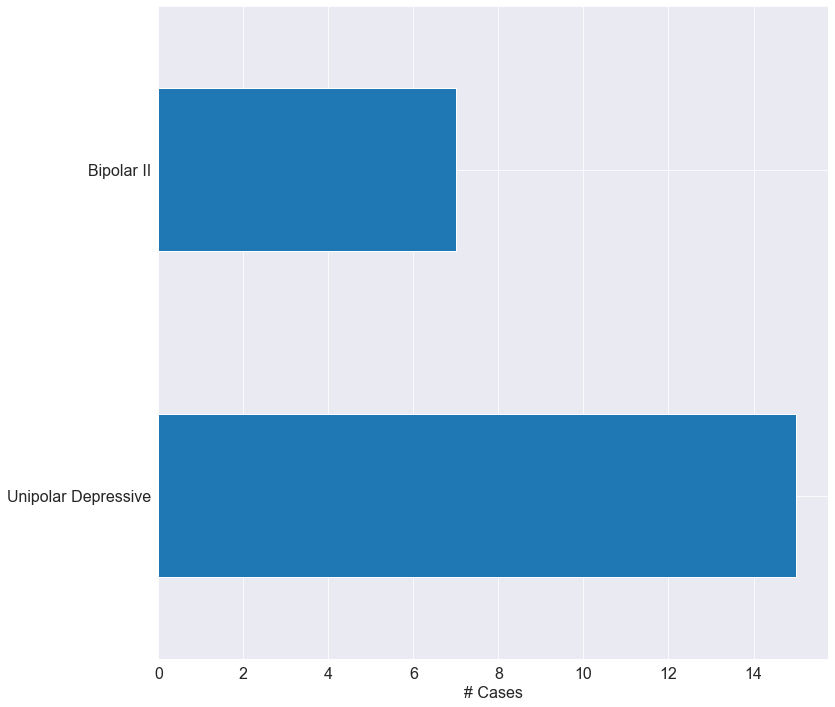

In [71]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(12,12))
counter = target["afftype"].value_counts()
counter.rename(index={1.0: "Bipolar II", 
                       0.0: "Unipolar Depressive"},
               inplace=True
              )
ax.set_xlabel("# Cases", size=16)
counter.plot(kind="barh", ax=ax)

## Recoding Original Dataset
**In order to genreate the counterfactual explanations, we need the data without the encoding used by the source of data.**

In [72]:
def inverse_transform(df):
    df_ = df.copy()
    df_["gender"].replace(to_replace={2.0: "male", 1.0: "female"}, inplace=True)
    df_["work"].replace(to_replace={2.0: "unemployed/sick/pension", 1.0: "working/studying"}, inplace=True)
    df_["marriage"].replace(to_replace={1.0: "married/cohabiting", 2.0: "single"}, inplace=True)
    df_["melanch"].replace(to_replace={1.0: "melancholia", 2.0: "no melancholia", 0.0: "no data"}, inplace=True)
    df_["inpatient"].replace(to_replace={1.0: "inpatient", 2.0: "outpatient"}, inplace=True)
    return df_

In [73]:
features = inverse_transform(features)

In [191]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(features, 
                                                                    target, 
                                                                    test_size=0.3, 
                                                                    random_state=14,
                                                                    stratify=target)

In [192]:
x_train


,days,gender,age,melanch,inpatient,edu,marriage,work,madrs1,madrs2,activity_mean,activity_std
20,14,female,65-69,no melancholia,inpatient,0,single,unemployed/sick/pension,29.0,28.0,287.349,279.429
13,14,female,60-64,no melancholia,outpatient,6-10,single,unemployed/sick/pension,28.0,19.0,205.845,262.523
1,18,male,40-44,no melancholia,outpatient,6-10,single,unemployed/sick/pension,24.0,11.0,153.673,330.808
2,13,female,45-49,no melancholia,outpatient,6-10,single,unemployed/sick/pension,24.0,25.0,265.300,399.881
3,13,male,25-29,no melancholia,outpatient,11-15,married/cohabiting,working/studying,20.0,16.0,451.672,497.075
4,13,male,50-54,no melancholia,outpatient,11-15,single,unemployed/sick/pension,26.0,26.0,267.576,340.471
21,16,female,30-34,no melancholia,inpatient,16-20,single,unemployed/sick/pension,29.0,23.0,440.540,415.779
12,14,male,35-39,no melancholia,outpatient,11-15,single,unemployed/sick/pension,18.0,13.0,390.093,383.131
15,16,female,45-49,no melancholia,outpatient,11-15,married/cohabiting,unemployed/sick/pension,13.0,17.0,338.069,424.913
17,13,male,50-54,no melancholia,inpatient,16-20,single,unemployed/sick/pension,26.0,21.0,269.876,333.094


### Model Training




In [193]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

In [194]:
categoric_features = [
    'gender', 
    'work', 
    'marriage',
    'melanch',
    'inpatient',
    "age",
    "edu"
]
numeric_features = set(features.columns)-set(categoric_features)

**Since the dataset is small, we need to precise to the categorical encoder the different categories of each categorical feature**

In [195]:
cat_types = []
for cat in categoric_features:
    cat_i = list(features[cat].unique())
    cat_types.append(cat_i)

In [196]:
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(categories=cat_types))])
preprocessor = ColumnTransformer(transformers=[('categorical', categorical_transformer, categoric_features)])


In [197]:
params_rf = {
    "n_estimators": 50,
    "max_depth": 8, 
}
rf = RandomForestClassifier(**params_rf)

In [198]:
#Model object: takes original data, processes it and applies the random forest
clf_rf = Pipeline(steps=[
                      ('preprocessor', preprocessor),
                      ('classifier', rf)
])
model = clf_rf.fit(x_train , y_train)

Text(0.5, 1.0, 'Confusion Matrix (Train set)')

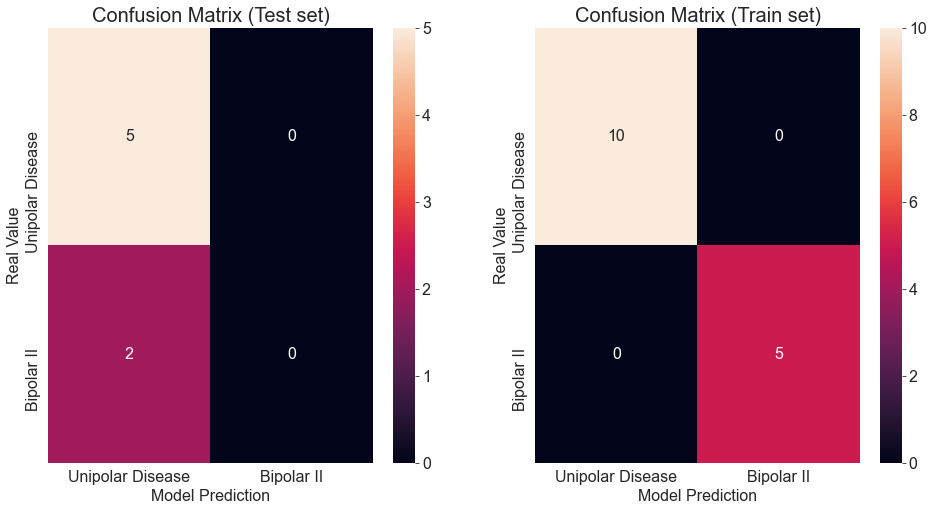

In [199]:
y_hat = clf_rf.predict(x_test)
cf = metrics.confusion_matrix(y_pred=y_hat, y_true=y_test)
cf_train = metrics.confusion_matrix(y_pred=clf_rf.predict(x_train), y_true=y_train)
names_df = [
    "Unipolar Disease",
    "Bipolar II"
]
cf_df = pd.DataFrame(data=cf, columns=names_df, index=names_df)
cf_train_df = pd.DataFrame(data=cf_train, columns=names_df, index=names_df)
fig, ax = plt.subplots(ncols=2, figsize=(16,8))

sns.heatmap(cf_df, fmt="d",annot=True, ax=ax[0])
ax[0].set_xlabel("Model Prediction", size=16)
ax[0].set_ylabel("Real Value", size=16)
ax[0].set_title("Confusion Matrix (Test set)", size=20)

sns.heatmap(cf_train_df, fmt="d",annot=True, ax=ax[1])
ax[1].set_xlabel("Model Prediction", size=16)
ax[1].set_ylabel("Real Value", size=16)
ax[1].set_title("Confusion Matrix (Train set)", size=20)

### DiCE 

In [200]:
#Loading the dice module
import dice_ml
from dice_ml.utils import helpers 
import json  

In [201]:
#DiCE data object
X = pd.concat([features, target], axis=1)
#{1.0: "Bipolar II", 0.0: "Unipolar Depressive"}
data = dice_ml.Data(dataframe=X, continuous_features=list(numeric_features), outcome_name='afftype')
#DiCE model object
model_exp = dice_ml.Model(model=model, backend='sklearn')
#Creates the explanations 
exp = dice_ml.Dice(data, model_exp, method="random")

In [205]:
#We take an example of our training set 
#We set the number of counterfactual explanations to 2. 
patient_index = 2
features_to_vary = [
    "marriage",
    #"days",
    #"melanch",
    #"inpatient",
    "work",
    "edu",
    "age"
]
e1 = exp.generate_counterfactuals(features[patient_index:patient_index+1], 
                                  total_CFs=2, 
                                  desired_class="opposite",
                                 random_seed=3434,
                                 features_to_vary=features_to_vary)
#Show counterfactual explanations
e1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:06<00:00,  6.45s/it]

Query instance (original outcome : 0)


,days,gender,age,melanch,inpatient,edu,marriage,work,madrs1,madrs2,activity_mean,activity_std,afftype
0,13,female,45-49,no melancholia,outpatient,6-10,single,unemployed/sick/pension,24.0,25.0,265.3,399.881,0



Diverse Counterfactual set (new outcome: 1.0)


,days,gender,age,melanch,inpatient,edu,marriage,work,madrs1,madrs2,activity_mean,activity_std,afftype
0,-,-,50-54,-,-,-,married/cohabiting,-,-,-,266.00099999998343,400.00099999999713,1
1,-,-,40-44,-,-,-,-,-,-,-,266.00099999998343,400.00099999999713,1


**The previous code can be modified in order to change the patient. The counterfactual example is displayed using a dataframe in which we find the features to vary, according to the bipolar disease predictive model, in order to change the output of the model. For the Patient *2*, the output of the model is that there is no bipolar disease. However, if the patient were a worker/student and the activty features were slighlty higher, then the model would have predicted a Bipolar II**